<a href="https://colab.research.google.com/github/EleanorJator/Dpro_Assignments-/blob/main/LSTM_Ass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Problem 1] Execution of various methods

In [1]:
'''Trains an LSTM model on the IMDB sentiment classification task.

The dataset is actually too small for LSTM to be of any advantage
compared to simpler, much faster methods such as TF-IDF + LogReg.

# Notes

- RNNs are tricky. Choice of batch size is important,
choice of loss and optimizer is critical, etc.
Some configurations won't converge.

- LSTM loss decrease patterns during training can be quite different
from what you see with CNNs/MLPs/etc.
'''
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb
from keras import backend as K

max_features = 20000
# cut texts after this number of words (among top max_features most common words)
maxlen = 80
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()

model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=15,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Loading data...
17464789/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)
Build model...
Train...
Epoch 1/15
782/782 [==============================] - 240s 301ms/step - loss: 0.4302 - accuracy: 0.7972 - val_loss: 0.3507 - val_accuracy: 0.8468
Epoch 2/15
782/782 [==============================] - 236s 302ms/step - loss: 0.2538 - accuracy: 0.8996 - val_loss: 0.3971 - val_accuracy: 0.8339
Epoch 3/15
782/782 [==============================] - 239s 305ms/step - loss: 0.1656 - accuracy: 0.9392 - val_loss: 0.4257 - val_accuracy: 0.8291
Epoch 4/15
782/782 [==============================] - 240s 306ms/step - loss: 0.1105 - accuracy: 0.9597 - val_loss: 0.5692 - val_accuracy: 0.8236
Epoch 5/15
782/782 [==============================] - 240s 307ms/step - loss: 0.0734 - accuracy: 0.9742 - val_loss: 0.6635 - val_accuracy: 0.8215
Epoch 6/15
782/782 [==================

Epoch 1/2
95/95 [==============================] - 1813s 19s/step - loss: 0.7978 - val_loss: 0.6690
Epoch 2/2
1/1 [==============================] - 1s 668ms/step


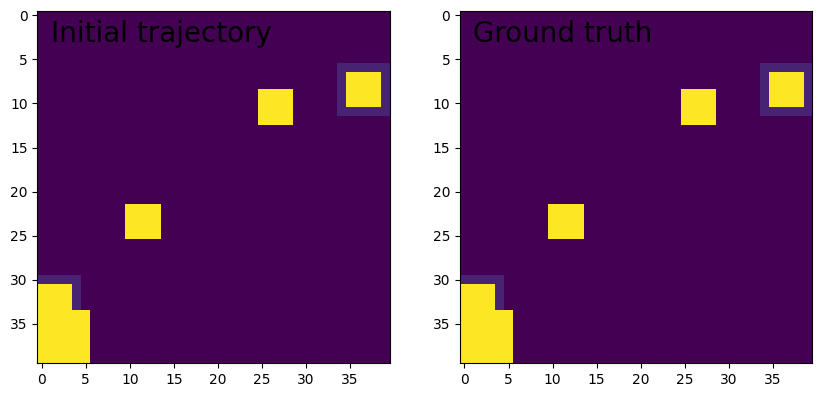

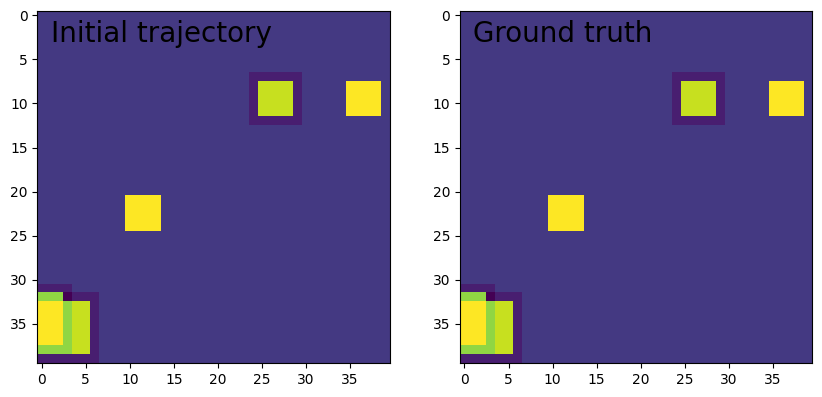

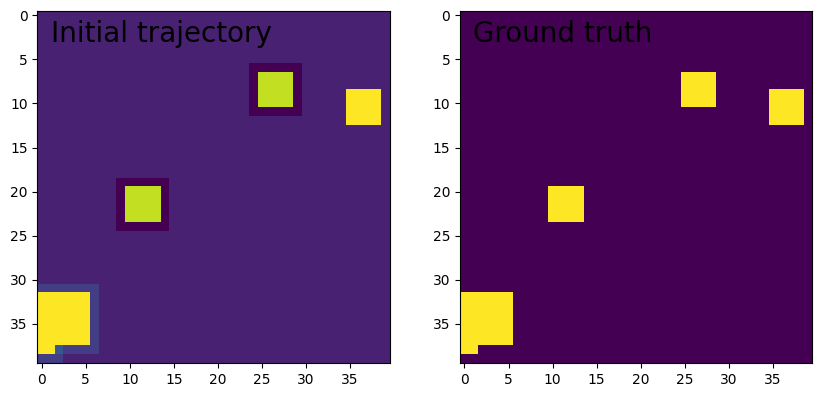

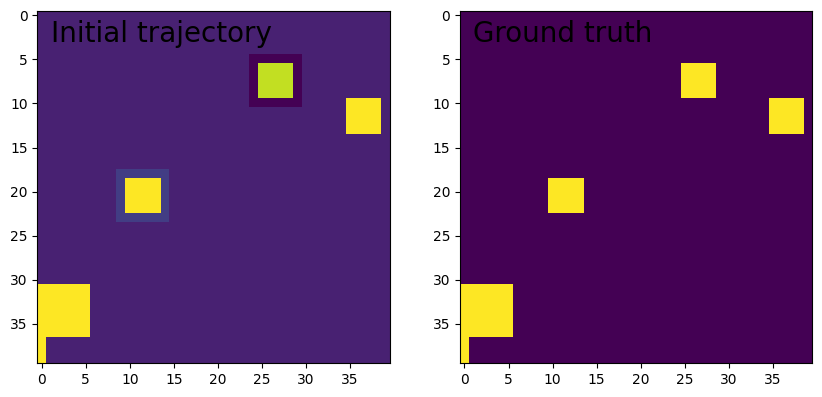

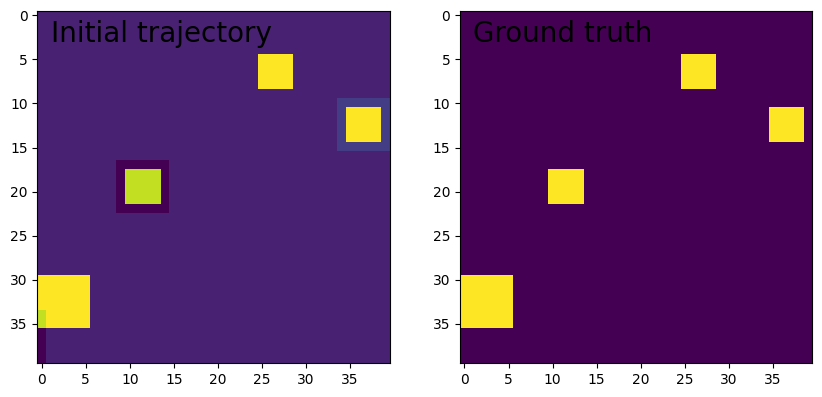

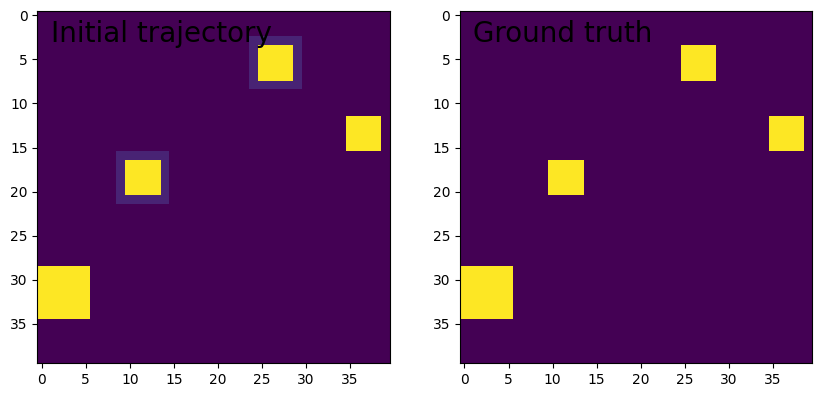

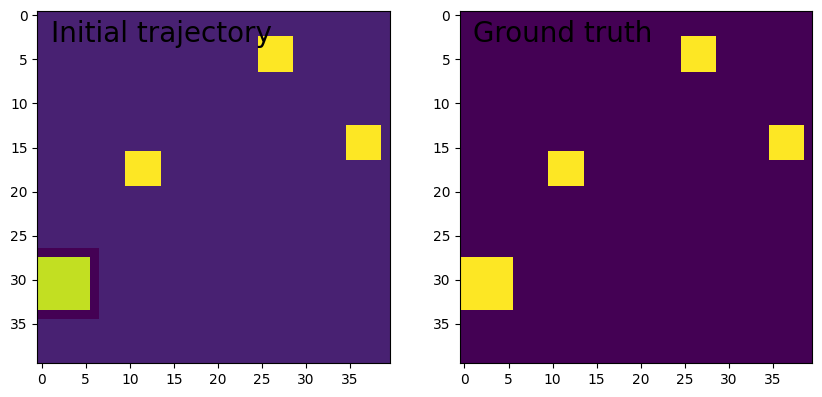

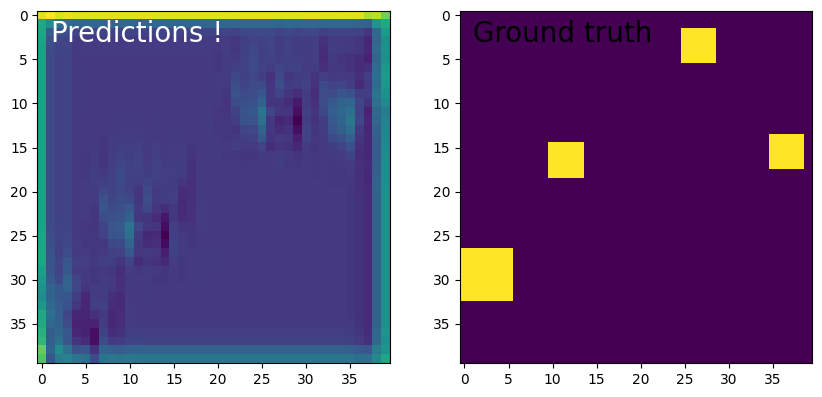

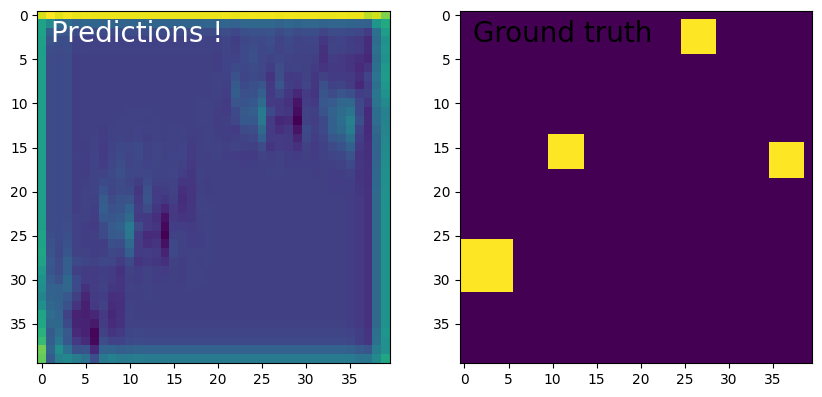

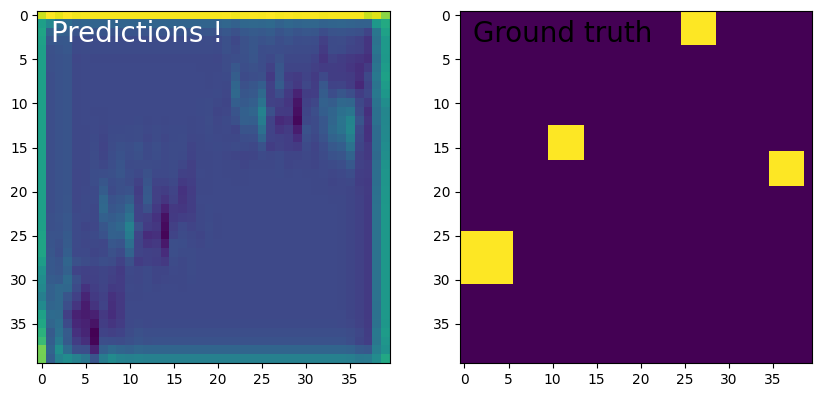

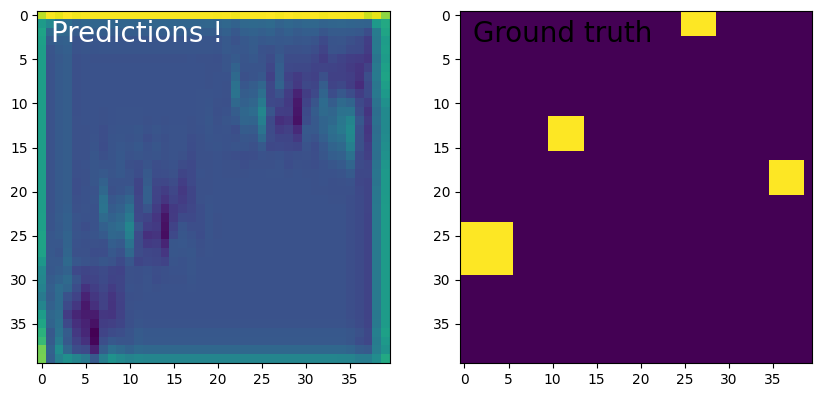

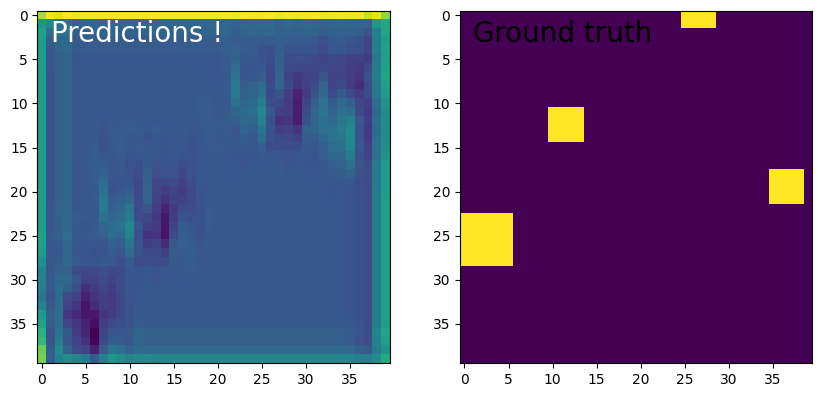

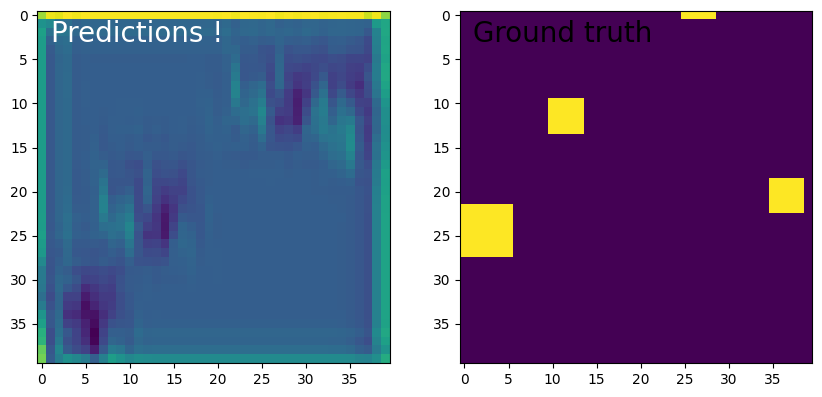

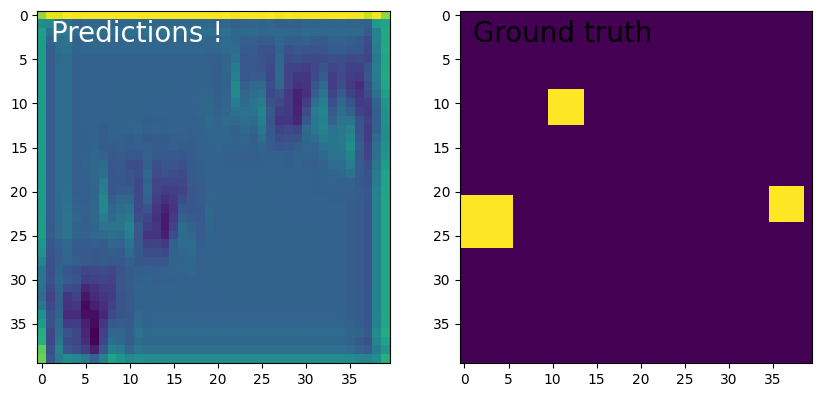

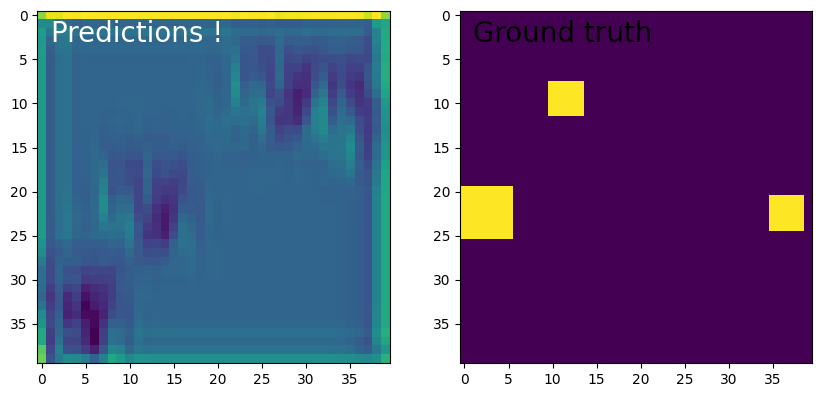

In [3]:
""" This script demonstrates the use of a convolutional LSTM network.

This network is used to predict the next frame of an artificially
generated movie which contains moving squares.
"""
from keras.models import Sequential
from keras.layers import Conv3D
from keras.layers import ConvLSTM2D
from keras.layers import BatchNormalization
import numpy as np
import pylab as plt
from keras import backend as K

if K.backend() == 'mxnet':
    raise NotImplementedError("MXNet Backend: ConvLSTM2D Layer is not supported yet.")

# We create a layer which take as input movies of shape
# (n_frames, width, height, channels) and returns a movie
# of identical shape.

seq = Sequential()
seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   input_shape=(None, 40, 40, 1),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
seq.compile(loss='binary_crossentropy', optimizer='adadelta')


# Artificial data generation:
# Generate movies with 3 to 7 moving squares inside.
# The squares are of shape 1x1 or 2x2 pixels,
# which move linearly over time.
# For convenience we first create movies with bigger width and height (80x80)
# and at the end we select a 40x40 window.

def generate_movies(n_samples=1200, n_frames=15):
    row = 80
    col = 80
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float32)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1),
                              dtype=np.float32)

    for i in range(n_samples):
        # Add 3 to 7 moving squares
        n = np.random.randint(3, 8)

        for j in range(n):
            # Initial position
            xstart = np.random.randint(20, 60)
            ystart = np.random.randint(20, 60)
            # Direction of motion
            directionx = np.random.randint(0, 3) - 1
            directiony = np.random.randint(0, 3) - 1

            # Size of the square
            w = np.random.randint(2, 4)

            for t in range(n_frames):
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t
                noisy_movies[i, t, x_shift - w: x_shift + w,
                             y_shift - w: y_shift + w, 0] += 1

                # Make it more robust by adding noise.
                # The idea is that if during inference,
                # the value of the pixel is not exactly one,
                # we need to train the network to be robust and still
                # consider it as a pixel belonging to a square.
                if np.random.randint(0, 2):
                    noise_f = (-1)**np.random.randint(0, 2)
                    noisy_movies[i, t,
                                 x_shift - w - 1: x_shift + w + 1,
                                 y_shift - w - 1: y_shift + w + 1,
                                 0] += noise_f * 0.1

                # Shift the ground truth by 1
                x_shift = xstart + directionx * (t + 1)
                y_shift = ystart + directiony * (t + 1)
                shifted_movies[i, t, x_shift - w: x_shift + w,
                               y_shift - w: y_shift + w, 0] += 1

    # Cut to a 40x40 window
    noisy_movies = noisy_movies[::, ::, 20:60, 20:60, ::]
    shifted_movies = shifted_movies[::, ::, 20:60, 20:60, ::]
    noisy_movies[noisy_movies >= 1] = 1
    shifted_movies[shifted_movies >= 1] = 1
    return noisy_movies, shifted_movies

# Train the network
noisy_movies, shifted_movies = generate_movies(n_samples=1200)
seq.fit(noisy_movies[:1000], shifted_movies[:1000], batch_size=10,
        epochs=2, validation_split=0.05)

# Testing the network on one movie
# feed it with the first 7 positions and then
# predict the new positions
which = 1004
track = noisy_movies[which][:7, ::, ::, ::]

for j in range(16):
    new_pos = seq.predict(track[np.newaxis, ::, ::, ::, ::])
    new = new_pos[::, -1, ::, ::, ::]
    track = np.concatenate((track, new), axis=0)


# And then compare the predictions
# to the ground truth
track2 = noisy_movies[which][::, ::, ::, ::]
for i in range(15):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(121)

    if i >= 7:
        ax.text(1, 3, 'Predictions !', fontsize=20, color='w')
    else:
        ax.text(1, 3, 'Initial trajectory', fontsize=20)

    toplot = track[i, ::, ::, 0]

    plt.imshow(toplot)
    ax = fig.add_subplot(122)
    plt.text(1, 3, 'Ground truth', fontsize=20)

    toplot = track2[i, ::, ::, 0]
    if i >= 2:
        toplot = shifted_movies[which][i - 1, ::, ::, 0]

    plt.imshow(toplot)
    plt.savefig('%i_animate.png' % (i + 1))

In [4]:
'''Trains an LSTM model on the IMDB sentiment classification task.

The dataset is actually too small for LSTM to be of any advantage
compared to simpler, much faster methods such as TF-IDF + LogReg.

# Notes

- RNNs are tricky. Choice of batch size is important,
choice of loss and optimizer is critical, etc.
Some configurations won't converge.

- LSTM loss decrease patterns during training can be quite different
from what you see with CNNs/MLPs/etc.
'''
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import SimpleRNN
from keras.datasets import imdb
from keras import backend as K

max_features = 20000
# this code cuts texts after this number of words (among top max_features most common words)
maxlen = 80
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()

model.add(Embedding(max_features, 128))
model.add(SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=2,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)
Build model...
Train...
Epoch 1/2
782/782 [==============================] - 69s 87ms/step - loss: 0.6762 - accuracy: 0.5588 - val_loss: 0.4761 - val_accuracy: 0.7746
Epoch 2/2
782/782 [==============================] - 7s 9ms/step - loss: 0.4884 - accuracy: 0.7770
Test score: 0.4883764088153839
Test accuracy: 0.7770400047302246


In [5]:
'''Trains an LSTM model on the IMDB sentiment classification task.

The dataset is actually too small for LSTM to be of any advantage
compared to simpler, much faster methods such as TF-IDF + LogReg.

# Notes

- RNNs are tricky. Choice of batch size is important,
choice of loss and optimizer is critical, etc.
Some configurations won't converge.

- LSTM loss decrease patterns during training can be quite different
from what you see with CNNs/MLPs/etc.
'''
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from tensorflow.keras.layers import GRU
from keras.datasets import imdb
from keras import backend as K

max_features = 20000
# cut texts after this number of words (among top max_features most common words)
maxlen = 80
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()

model.add(Embedding(max_features, 128))
model.add(GRU(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=2,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)
Build model...
Train...
Epoch 1/2
782/782 [==============================] - 193s 243ms/step - loss: 0.4371 - accuracy: 0.7906 - val_loss: 0.3630 - val_accuracy: 0.8464
Epoch 2/2
782/782 [==============================] - 19s 24ms/step - loss: 0.3711 - accuracy: 0.8491
Test score: 0.3711102604866028
Test accuracy: 0.849120020866394


In [6]:
'''Trains an LSTM model on the IMDB sentiment classification task.

The dataset is actually too small for LSTM to be of any advantage
compared to simpler, much faster methods such as TF-IDF + LogReg.

# Notes

- RNNs are tricky. Choice of batch size is important,
choice of loss and optimizer is critical, etc.
Some configurations won't converge.

- LSTM loss decrease patterns during training can be quite different
from what you see with CNNs/MLPs/etc.
'''
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from tensorflow.keras.layers import SimpleRNN
from keras.datasets import imdb
from keras.datasets import reuters
from keras import backend as K

max_features = 20000
# cut texts after this number of words (among top max_features most common words)
maxlen = 80
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = reuters.load_data(
    path="reuters.npz",
    num_words=max_features,
    skip_top=0,
    maxlen=None,
    test_split=0.2,
    seed=113,
    start_char=1,
    oov_char=2,
    index_from=3,
)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()

model.add(Embedding(max_features, 128))
model.add(SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=2,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Loading data...
2110848/2110848 [==============================] - 0s 0us/step
8982 train sequences
2246 test sequences
Pad sequences (samples x time)
x_train shape: (8982, 80)
x_test shape: (2246, 80)
Build model...
Train...
Epoch 1/2
281/281 [==============================] - 24s 75ms/step - loss: -221.7660 - accuracy: 0.0477 - val_loss: -401.2792 - val_accuracy: 0.0467
Epoch 2/2
71/71 [==============================] - 1s 9ms/step - loss: -696.3920 - accuracy: 0.0467
Test score: -696.3919677734375
Test accuracy: 0.0467497780919075


In [7]:
'''Trains an LSTM model on the IMDB sentiment classification task.

The dataset is actually too small for LSTM to be of any advantage
compared to simpler, much faster methods such as TF-IDF + LogReg.

# Notes

- RNNs are tricky. Choice of batch size is important,
choice of loss and optimizer is critical, etc.
Some configurations won't converge.

- LSTM loss decrease patterns during training can be quite different
from what you see with CNNs/MLPs/etc.
'''
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM
from keras.datasets import reuters
from keras import backend as K

max_features = 20000
# cut texts after this number of words (among top max_features most common words)
maxlen = 80
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = reuters.load_data(
    path="reuters.npz",
    num_words=max_features,
    skip_top=0,
    maxlen=None,
    test_split=0.2,
    seed=113,
    start_char=1,
    oov_char=2,
    index_from=3,
)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()

model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=2,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Loading data...
8982 train sequences
2246 test sequences
Pad sequences (samples x time)
x_train shape: (8982, 80)
x_test shape: (2246, 80)
Build model...
Train...
Epoch 1/2
281/281 [==============================] - 73s 249ms/step - loss: -242.5942 - accuracy: 0.0479 - val_loss: -399.5824 - val_accuracy: 0.0467
Epoch 2/2
71/71 [==============================] - 2s 29ms/step - loss: -681.9728 - accuracy: 0.0467
Test score: -681.9728393554688
Test accuracy: 0.0467497780919075


[QProblem  3] Explanation of other classes

RNN:
The RNN class in Keras is a base class for recurrent layers. It is typically used indirectly through more specific subclasses like SimpleRNN, LSTM, and GRU. It allows you to build custom RNNs if needed.

SimpleRNNCell:

SimpleRNNCell is the cell class for SimpleRNN.
A cell is the building block for RNN layers.
The SimpleRNNCell implements the basic RNN cell, which is used internally by the SimpleRNN layer. This cell processes one time step at a time.

GRUCell:

GRUCell is the cell class for GRU layers.
A GRU (Gated Recurrent Unit) cell is a type of RNN cell that uses gating mechanisms to better capture dependencies in sequences.
 The GRUCell is used internally by the GRU layer and processes one time step at a time.

LSTMCell:

LSTMCell is the cell class for LSTM layers.
 An LSTM (Long Short-Term Memory) cell is a type of RNN cell designed to capture long-term dependencies using mechanisms like input gates, output gates, and forget gates.
 The LSTMCell is used internally by the LSTM layer and processes one time step at a time.

StackedRNNCells:

StackedRNNCells is a utility that allows you to stack multiple RNN cells together. This can be useful for creating deeper RNN architectures by combining multiple layers of RNN cells.
For example, you can stack LSTMCell or GRUCell to create a deeper RNN model.

CuDNNGRU:

CuDNNGRU is a GPU-optimized version of the GRU layer.
It leverages NVIDIA's cuDNN library to provide significant speed improvements for training GRU models on compatible hardware. However, it is less flexible and only works on GPU.

CuDNNLSTM:

CuDNNLSTM is a GPU-optimized version of the LSTM layer. Like CuDNNGRU, it uses NVIDIA's cuDNN library for faster training on compatible hardware. It is also less flexible and only works on GPU.